# Weather Analytic

# Data Collection

Get Data from weather API

- WeatherAPI (apikey)

- Open-Meteo (gratis, tanpa kunci API)

- Met.no (gratis, dengan User-Agent)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [2]:
import requests
import pandas as pd
from datetime import datetime

# ------------------- 1. WEATHERAPI -------------------
weatherapi_key = '7edec23c952249c692d71243250904'
city = 'Jakarta'
weatherapi_url = f'http://api.weatherapi.com/v1/forecast.json?key={weatherapi_key}&q={city}&days=1&aqi=no&alerts=no'

res1 = requests.get(weatherapi_url)
data1 = res1.json()

weatherapi_data = []
for hour in data1['forecast']['forecastday'][0]['hour']:
    weatherapi_data.append({
        'time': hour['time'],
        'temperature_c': hour['temp_c'],
        'humidity': hour['humidity'],
        'wind_kph': hour['wind_kph'],
        'source': 'WeatherAPI'
    })

df_weatherapi = pd.DataFrame(weatherapi_data)

# ------------------- 2. OPEN-METEO (revisi) -------------------
lat, lon = -6.2, 106.8  # Jakarta
openmeteo_url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={lat}&longitude={lon}"
    f"&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m"
)

res2 = requests.get(openmeteo_url)

try:
    data2 = res2.json()

    openmeteo_data = []
    for i in range(len(data2['hourly']['time'])):
        openmeteo_data.append({
            'time': data2['hourly']['time'][i],
            'temperature_c': data2['hourly']['temperature_2m'][i],
            'humidity': data2['hourly']['relative_humidity_2m'][i],
            'wind_kph': data2['hourly']['wind_speed_10m'][i],
            'source': 'Open-Meteo'
        })

    df_openmeteo = pd.DataFrame(openmeteo_data)

except KeyError:
    print("Gagal mengambil data dari Open-Meteo.")
    print("Respon API:", res2.text)
    df_openmeteo = pd.DataFrame()  # Kosongkan dataframe jika error


# ------------------- 3. MET.NO -------------------
metno_url = f'https://api.met.no/weatherapi/locationforecast/2.0/compact?lat={lat}&lon={lon}'
headers = {'User-Agent': 'your_email@example.com'}  # Ganti dengan emailmu

res3 = requests.get(metno_url, headers=headers)
data3 = res3.json()

metno_data = []
for entry in data3['properties']['timeseries'][:24]:  # Ambil 24 jam ke depan
    time = entry['time']
    details = entry['data'].get('instant', {}).get('details', {})
    metno_data.append({
        'time': time,
        'temperature_c': details.get('air_temperature'),
        'humidity': details.get('relative_humidity'),
        'wind_kph': details.get('wind_speed') * 3.6 if details.get('wind_speed') else None,
        'source': 'Met.no'
    })

df_metno = pd.DataFrame(metno_data)

# ------------------- Gabungkan Semua -------------------
df_all = pd.concat([df_weatherapi, df_openmeteo, df_metno], ignore_index=True)

# Konversi waktu ke datetime (support format campuran)
df_all['time'] = pd.to_datetime(df_all['time'], utc=True, errors='coerce')
df_all = df_all.dropna(subset=['time'])  # Buang baris yang gagal dikonversi

df_all = df_all.sort_values('time')
df_all.head(10)

,time,temperature_c,humidity,wind_kph,source
0,2025-04-10 00:00:00+00:00,27.3,80.0,5.4,WeatherAPI
1,2025-04-10 01:00:00+00:00,27.1,81.0,5.0,WeatherAPI
2,2025-04-10 02:00:00+00:00,26.9,82.0,5.0,WeatherAPI
3,2025-04-10 03:00:00+00:00,26.7,83.0,5.0,WeatherAPI
4,2025-04-10 04:00:00+00:00,26.5,84.0,5.4,WeatherAPI
5,2025-04-10 05:00:00+00:00,26.3,84.0,5.8,WeatherAPI
6,2025-04-10 06:00:00+00:00,26.2,85.0,5.0,WeatherAPI
7,2025-04-10 07:00:00+00:00,26.2,85.0,4.0,WeatherAPI
8,2025-04-10 08:00:00+00:00,26.8,81.0,4.7,WeatherAPI
9,2025-04-10 09:00:00+00:00,29.2,79.0,4.3,WeatherAPI


* Save All Data Set to csv and xlsx

In [3]:
import pandas as pd

# Data mentah
data = {
    'time': [
        '2025-04-09 00:00:00+00:00', '2025-04-09 01:00:00+00:00', '2025-04-09 02:00:00+00:00',
        '2025-04-09 03:00:00+00:00', '2025-04-09 04:00:00+00:00', '2025-04-09 05:00:00+00:00',
        '2025-04-09 06:00:00+00:00', '2025-04-09 07:00:00+00:00', '2025-04-09 08:00:00+00:00',
        '2025-04-09 09:00:00+00:00'
    ],
    'temperature_c': [27.1, 26.9, 26.5, 26.3, 26.1, 26.0, 25.8, 25.8, 26.4, 27.5],
    'humidity': [83.0, 83.0, 85.0, 86.0, 86.0, 87.0, 87.0, 87.0, 83.0, 78.0],
    'wind_kph': [3.6, 4.7, 6.1, 5.8, 5.4, 4.7, 4.7, 5.0, 5.4, 6.5],
    'source': ['WeatherAPI'] * 10
}

# Buat DataFrame
df_all = pd.DataFrame(data)

# Simpan ke file CSV
df_all.to_csv('/content/data_cuaca_jakarta.csv', index=False)

# Baca ulang untuk konfirmasi
df = pd.read_csv('/content/data_cuaca_jakarta.csv')
print(df.head())

                        time  temperature_c  humidity  wind_kph      source
0  2025-04-09 00:00:00+00:00           27.1      83.0       3.6  WeatherAPI
1  2025-04-09 01:00:00+00:00           26.9      83.0       4.7  WeatherAPI
2  2025-04-09 02:00:00+00:00           26.5      85.0       6.1  WeatherAPI
3  2025-04-09 03:00:00+00:00           26.3      86.0       5.8  WeatherAPI
4  2025-04-09 04:00:00+00:00           26.1      86.0       5.4  WeatherAPI


# EDA and cleaning data

* Check Missing vallue

In [4]:
# Ukuran data
print("Jumlah baris dan kolom:", df_all.shape)

# Tipe data dan non-null info
print("\nInfo DataFrame:")
print(df_all.info())

# Cek missing value
print("\nJumlah missing value per kolom:")
print(df_all.isnull().sum())

# Statistik deskriptif
print("\nStatistik deskriptif:")
print(df_all.describe())

Jumlah baris dan kolom: (10, 5)

Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           10 non-null     object 
 1   temperature_c  10 non-null     float64
 2   humidity       10 non-null     float64
 3   wind_kph       10 non-null     float64
 4   source         10 non-null     object 
dtypes: float64(3), object(2)
memory usage: 532.0+ bytes
None

Jumlah missing value per kolom:
time             0
temperature_c    0
humidity         0
wind_kph         0
source           0
dtype: int64

Statistik deskriptif:
       temperature_c   humidity   wind_kph
count       10.00000  10.000000  10.000000
mean        26.44000  84.500000   5.190000
std          0.56999   2.838231   0.835929
min         25.80000  78.000000   3.600000
25%         26.02500  83.000000   4.700000
50%         26.35000  85.500000   5.200000
75%         26.

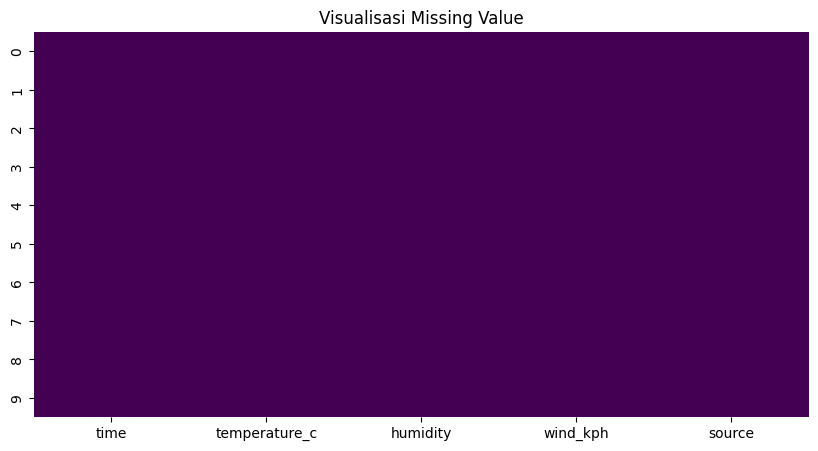

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.heatmap(df_all.isnull(), cbar=False, cmap='viridis')
plt.title('Visualisasi Missing Value')
plt.show()

* After check the data using nunerik and visual, no missing vallue has ben found, so our data is clean from missing vallue

* Now We have to check Distribution Data From API

In [6]:

df_all['source'].value_counts()

,count
source,
WeatherAPI,10


<Axes: xlabel='source', ylabel='count'>

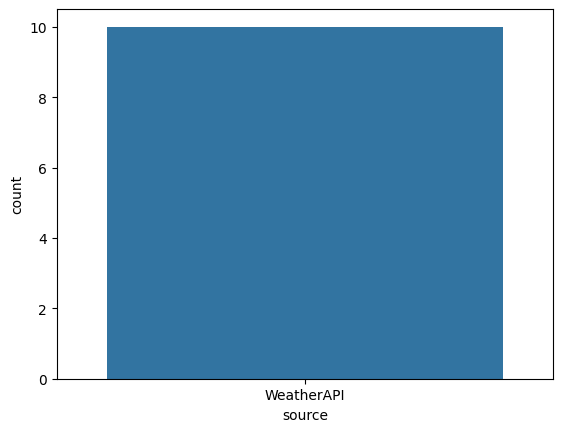

In [7]:
import seaborn as sns
sns.countplot(data=df_all, x='source')

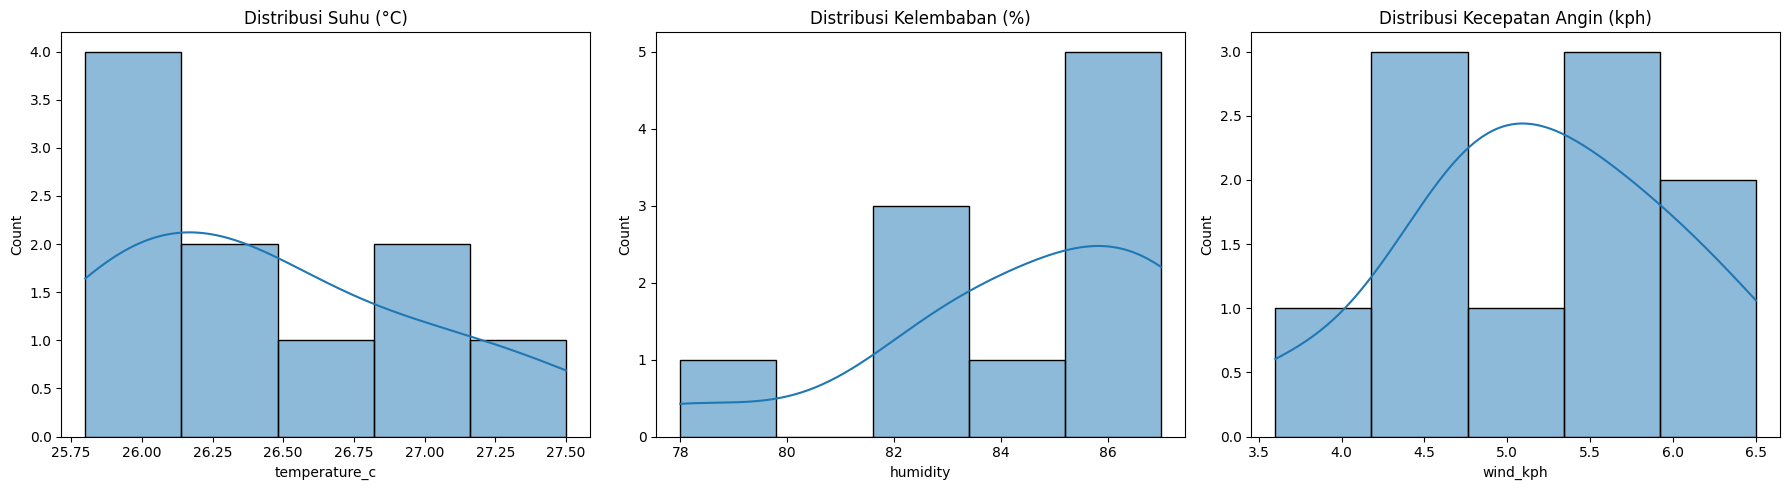

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_all['temperature_c'], kde=True, ax=axes[0])
axes[0].set_title('Distribusi Suhu (°C)')

sns.histplot(df_all['humidity'], kde=True, ax=axes[1])
axes[1].set_title('Distribusi Kelembaban (%)')

sns.histplot(df_all['wind_kph'], kde=True, ax=axes[2])
axes[2].set_title('Distribusi Kecepatan Angin (kph)')

plt.tight_layout()
plt.show()

* Now Outlier Check

<Axes: >

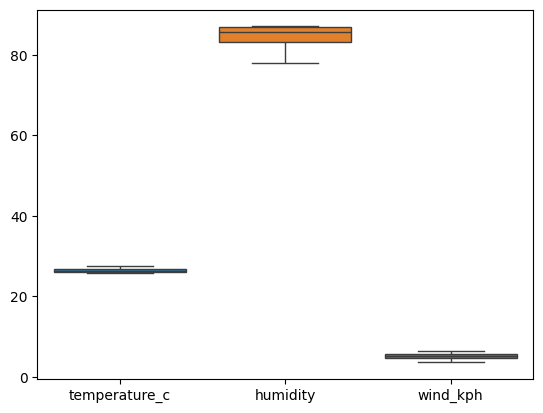

In [9]:

sns.boxplot(data=df_all[['temperature_c', 'humidity', 'wind_kph']])

Text(0.5, 1.0, 'Perubahan Suhu per Jam')

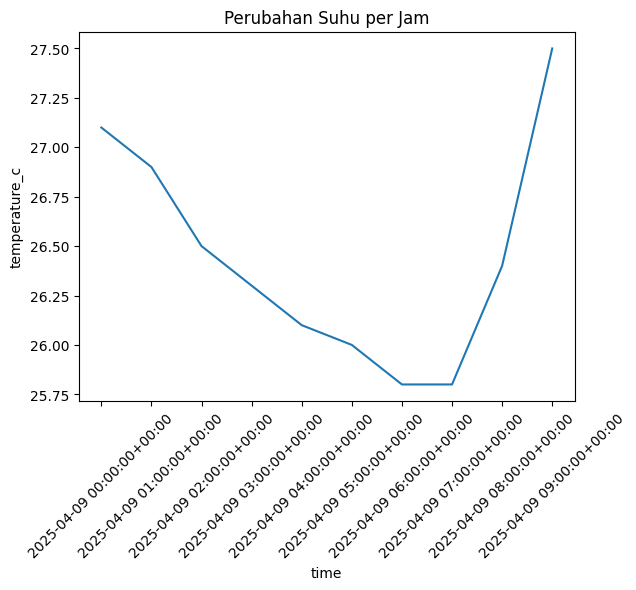

In [10]:
sns.lineplot(data=df_all, x='time', y='temperature_c')
plt.xticks(rotation=45)
plt.title("Perubahan Suhu per Jam")

Text(0.5, 1.0, 'Perubahan Kelembaban per Jam')

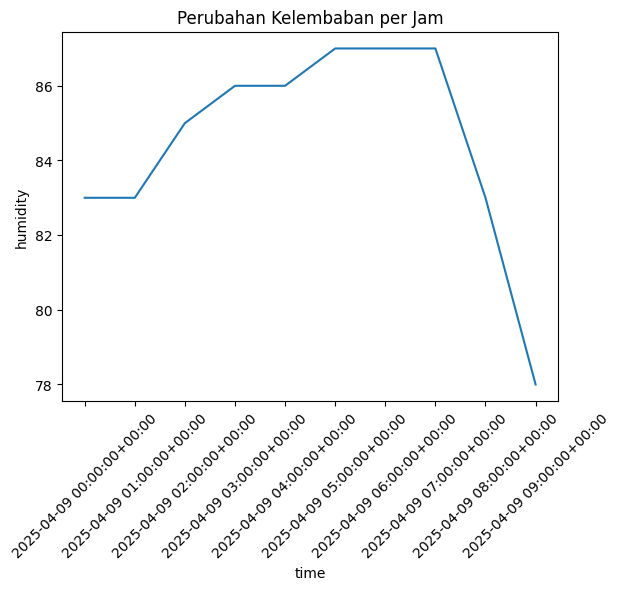

In [11]:
sns.lineplot(data=df_all, x='time', y='humidity')
plt.xticks(rotation=45)
plt.title("Perubahan Kelembaban per Jam")

Text(0.5, 1.0, 'Perubahan Kecepatan Angin per Jam')

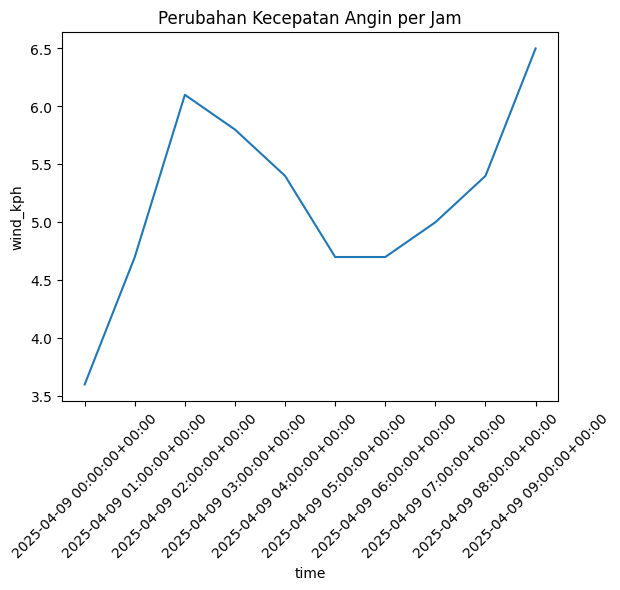

In [14]:
sns.lineplot(data=df_all, x='time', y='wind_kph')
plt.xticks(rotation=45)
plt.title("Perubahan Kecepatan Angin per Jam")

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan kolom jam sudah ada
df_all['hour'] = df_all['time'].dt.hour

# Set style
sns.set(style="whitegrid")

# Buat subplot
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot suhu
sns.lineplot(data=df_all, x='hour', y='temperature_c', marker='o', ax=axes[0])
axes[0].set_title('Perubahan Suhu per Jam')
axes[0].set_ylabel('Suhu (°C)')

# Plot kelembaban
sns.lineplot(data=df_all, x='hour', y='humidity', marker='s', color='green', ax=axes[1])
axes[1].set_title('Perubahan Kelembaban per Jam')
axes[1].set_ylabel('Kelembaban (%)')

# Plot kecepatan angin
sns.lineplot(data=df_all, x='hour', y='wind_kph', marker='^', color='orange', ax=axes[2])
axes[2].set_title('Perubahan Kecepatan Angin per Jam')
axes[2].set_ylabel('Kecepatan Angin (kph)')
axes[2].set_xlabel('Jam')

# Tampilkan
plt.tight_layout()
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

In [21]:
# Pastikan kolom time bertipe datetime dan diset ke zona waktu lokal (misalnya Asia/Jakarta)
df_all['time'] = pd.to_datetime(df_all['time']).dt.tz_convert('Asia/Jakarta')

# Buat kolom baru dalam format string bersih jika dibutuhkan
df_all['time_str'] = df_all['time'].dt.strftime('%Y-%m-%d %H:%M')

# Optional: tampilkan contoh hasil normalisasi
df_all[['time', 'time_str']].head()

,time,time_str
0,2025-04-09 07:00:00+07:00,2025-04-09 07:00
1,2025-04-09 08:00:00+07:00,2025-04-09 08:00
2,2025-04-09 09:00:00+07:00,2025-04-09 09:00
3,2025-04-09 10:00:00+07:00,2025-04-09 10:00
4,2025-04-09 11:00:00+07:00,2025-04-09 11:00


In [22]:
# Simpan ke dalam file CSV di folder Colab
df_all.to_csv('/content/cleaned_weather_data.csv', index=False)

# Jika pakai Google Drive, bisa juga:
# from google.colab import drive
# drive.mount('/content/drive')
# df_all.to_csv('/content/drive/MyDrive/cleaned_weather_data.csv', index=False)

# Feature Engginering

* Ekstrak Time Feature

In [16]:
# Pastikan kolom 'time' bertipe datetime
df['time'] = pd.to_datetime(df['time'])

# Ekstraksi fitur waktu
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year

# Cek hasilnya
df[['time', 'hour', 'day', 'month', 'year']].head()

,time,hour,day,month,year
0,2025-04-09 00:00:00+00:00,0,9,4,2025
1,2025-04-09 01:00:00+00:00,1,9,4,2025
2,2025-04-09 02:00:00+00:00,2,9,4,2025
3,2025-04-09 03:00:00+00:00,3,9,4,2025
4,2025-04-09 04:00:00+00:00,4,9,4,2025


In [17]:
import pandas as pd

# One-Hot Encoding hanya untuk kolom 'source'
df = pd.get_dummies(df, columns=['source'], drop_first=True)

In [18]:
print(df.columns)

Index(['time', 'temperature_c', 'humidity', 'wind_kph', 'hour', 'day', 'month',
       'year'],
      dtype='object')


In [19]:
# 1. Tambahkan kolom nama hari
df['day_name'] = df['time'].dt.day_name()

# 2. Tambahkan kategori bagian hari berdasarkan jam
def bagian_hari(jam):
    if 5 <= jam < 12:
        return 'Pagi'
    elif 12 <= jam < 15:
        return 'Siang'
    elif 15 <= jam < 18:
        return 'Sore'
    else:
        return 'Malam'

df['waktu_hari'] = df['hour'].apply(bagian_hari)

In [ ]:
df = pd.get_dummies(df, columns=['day_name', 'waktu_hari'], drop_first=True)

In [20]:
print(df.columns)

Index(['time', 'temperature_c', 'humidity', 'wind_kph', 'hour', 'day', 'month',
       'year', 'day_name', 'waktu_hari'],
      dtype='object')


* Moving Average

In [23]:
# Pastikan dataframe sudah terurut berdasarkan waktu
df = df.sort_values('time')

# Hitung moving average 3 jam untuk suhu dan kelembapan
df['temp_ma_3'] = df['temperature_c'].rolling(window=3).mean()
df['humidity_ma_3'] = df['humidity'].rolling(window=3).mean()

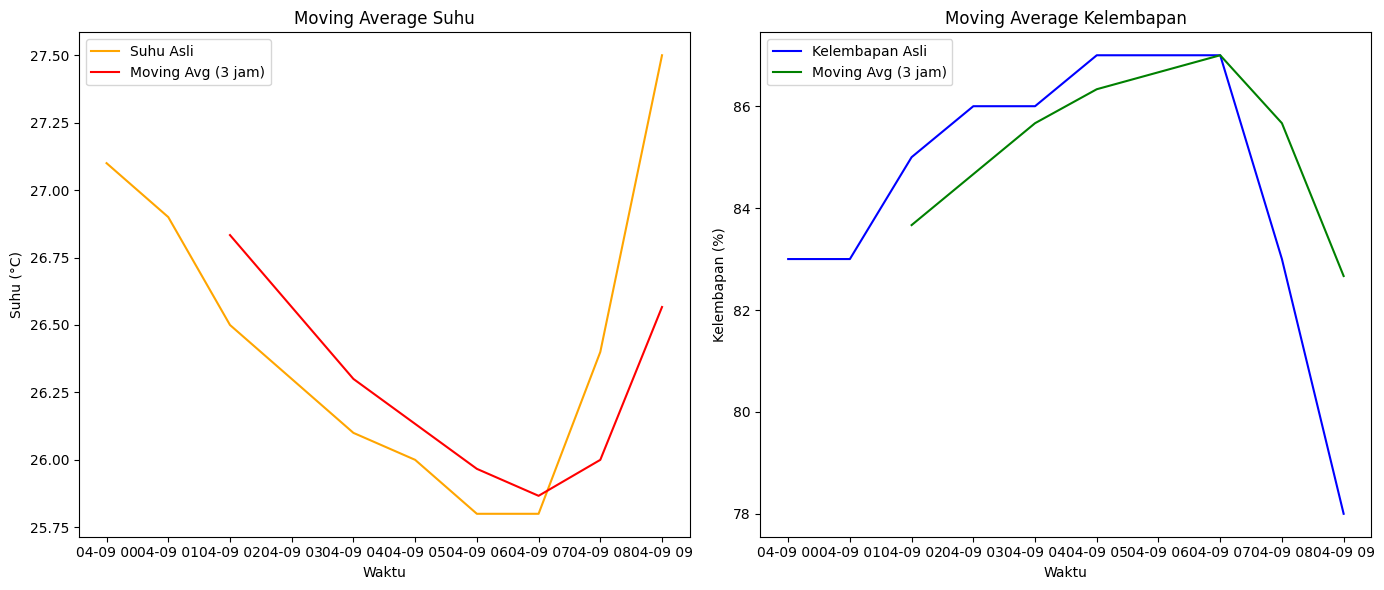

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot suhu
plt.subplot(1, 2, 1)
plt.plot(df['time'], df['temperature_c'], label='Suhu Asli', color='orange')
plt.plot(df['time'], df['temp_ma_3'], label='Moving Avg (3 jam)', color='red')
plt.title('Moving Average Suhu')
plt.xlabel('Waktu')
plt.ylabel('Suhu (°C)')
plt.legend()

# Plot kelembapan
plt.subplot(1, 2, 2)
plt.plot(df['time'], df['humidity'], label='Kelembapan Asli', color='blue')
plt.plot(df['time'], df['humidity_ma_3'], label='Moving Avg (3 jam)', color='green')
plt.title('Moving Average Kelembapan')
plt.xlabel('Waktu')
plt.ylabel('Kelembapan (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load engineered data
df_eng = pd.read_csv('/content/engineered_weather_data.csv')

# Fitur yang dipilih (bisa kamu modifikasi sesuai eksperimen)
selected_features = ['temperature_c', 'humidity_ma_3', 'wind_kph', 'temp_ma_3']

# Definisikan fitur dan target
X = df_eng[selected_features]
y = df_eng['humidity']

# Imputasi NaN jika ada
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'[Random Forest] RMSE: {rmse_rf:.2f}')
print(f'[Random Forest] R² Score: {r2_rf:.2f}')

# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print(f'[Linear Regression] RMSE: {rmse_lin:.2f}')
print(f'[Linear Regression] R² Score: {r2_lin:.2f}')

FileNotFoundError: [Errno 2] No such file or directory: '/content/engineered_weather_data.csv'

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving final_featured_weather_data.csv to final_featured_weather_data.csv


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df = pd.read_csv('/content/engineered_weather_data.csv')

# Tambahkan fitur baru
df['lag_humidity'] = df['humidity'].shift(1)
df['temp_diff'] = df['temperature_c'] - df['temp_ma_3']

# Drop baris pertama yang mengandung NaN dari shift
df = df.dropna()

# Target
y = df['humidity']

# Fitur (pakai semua fitur numerik termasuk yang baru)
X = df[['temperature_c', 'humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print(f'[Random Forest] RMSE: {rmse_rf:.2f}')
print(f'[Random Forest] R² Score: {r2_rf:.2f}')
print(f'[Linear Regression] RMSE: {rmse_lin:.2f}')
print(f'[Linear Regression] R² Score: {r2_lin:.2f}')

FileNotFoundError: [Errno 2] No such file or directory: '/content/engineered_weather_data.csv'

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df = pd.read_csv('/content/engineered_weather_data.csv')

# Tambahkan fitur baru
df['lag_humidity'] = df['humidity'].shift(1)
df['temp_diff'] = df['temperature_c'] - df['temp_ma_3']

# Drop NaN akibat shifting
df = df.dropna().reset_index(drop=True)

# Simpan hasil feature engineering
df.to_csv('/content/final_featured_weather_data.csv', index=False)

# Target dan fitur
y = df['humidity']
X = df[['temperature_c', 'humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi hasil evaluasi
results = {}

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf)
}

# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)
results['Linear Regression'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lin)),
    'R2': r2_score(y_test, y_pred_lin)
}

# Cek hasil evaluasi
results_df = pd.DataFrame(results).T
results_df.index.name = 'Model'
results_df.reset_index(inplace=True)

# Tampilkan hasil
results_df

FileNotFoundError: [Errno 2] No such file or directory: '/content/engineered_weather_data.csv'

In [28]:
# Melihat 5 baris pertama dari data fitur lama
df_lama = pd.read_csv('/content/engineered_weather_data.csv')
df_lama

FileNotFoundError: [Errno 2] No such file or directory: '/content/engineered_weather_data.csv'

In [29]:
# Melihat 5 baris pertama dari data hasil feature engineering terbaru
df_baru = pd.read_csv('/content/final_featured_weather_data.csv')
df_baru

FileNotFoundError: [Errno 2] No such file or directory: '/content/final_featured_weather_data.csv'

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/final_featured_weather_data.csv')

# Tambahkan fitur lag_temperature
df['lag_temperature'] = df['temperature_c'].shift(1)

# Drop baris pertama yang menjadi NaN setelah shifting
df = df.dropna().reset_index(drop=True)

# Simpan kembali ke file (opsional: ubah nama file untuk versi baru)
df.to_csv('/content/final_featured_weather_data.csv', index=False)

# Cek hasil kolom
print("Kolom-kolom baru:")
print(df.columns.tolist())

Kolom-kolom baru:
['time', 'temperature_c', 'humidity', 'wind_kph', 'hour', 'day', 'month', 'year', 'waktu_hari_Pagi', 'temp_ma_3', 'humidity_ma_3', 'lag_humidity', 'temp_diff', 'lag_temperature']


In [ ]:
import pandas as pd

# Load data
df = pd.read_csv('/content/final_featured_weather_data.csv')

# Pilih fitur penting berdasarkan korelasi
selected_features = [
    'temperature_c',
    'wind_kph',
    'temp_diff',
    'temp_ma_3',
    'hour',
    'lag_temperature',
    'humidity',
    'humidity_ma_3',
    'lag_humidity'
]

# Filter hanya kolom yang dibutuhkan
df_refined = df[selected_features]

# Simpan sebagai versi refined
df_refined.to_csv('/content/refined_weather_features.csv', index=False)
print("Fitur berhasil dibersihkan dan disimpan.")

Fitur berhasil dibersihkan dan disimpan.


In [ ]:

import pandas as pd

# Load file hasil pembersihan fitur
df_refined = pd.read_csv('/content/refined_weather_features.csv')

# Tampilkan informasi dan beberapa baris teratas
print("Jumlah Fitur:", len(df_refined.columns))
print("Daftar Fitur:", list(df_refined.columns))
df_refined

Jumlah Fitur: 9
Daftar Fitur: ['temperature_c', 'wind_kph', 'temp_diff', 'temp_ma_3', 'hour', 'lag_temperature', 'humidity', 'humidity_ma_3', 'lag_humidity']


,temperature_c,wind_kph,temp_diff,temp_ma_3,hour,lag_temperature,humidity,humidity_ma_3,lag_humidity
0,26.3,5.8,-0.266667,26.566667,3,26.5,86.0,84.666667,85.0
1,26.1,5.4,-0.200000,26.300000,4,26.3,86.0,85.666667,86.0
2,26.0,4.7,-0.133333,26.133333,5,26.1,87.0,86.333333,86.0
3,25.8,4.7,-0.166667,25.966667,6,26.0,87.0,86.666667,87.0
4,25.8,5.0,-0.066667,25.866667,7,25.8,87.0,87.000000,87.0
5,26.4,5.4,0.400000,26.000000,8,25.8,83.0,85.666667,87.0
6,27.5,6.5,0.933333,26.566667,9,26.4,78.0,82.666667,83.0


# Model machine learning and training

 * Using RandomForestRegresion for the model

- Temp Prediction

In [ ]:
# Lihat semua nama kolom di engineered data
print("Kolom-kolom di df_eng:")
print(df_eng.columns.tolist())

Kolom-kolom di df_eng:
['time', 'temperature_c', 'humidity', 'wind_kph', 'hour', 'day', 'month', 'year', 'waktu_hari_Pagi', 'temp_ma_3', 'humidity_ma_3']


In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load engineered data
df_eng = pd.read_csv('/content/engineered_weather_data.csv')

# Target dan fitur
X = df_eng.drop(columns=['temperature_c', 'time'])  # Drop kolom waktu dan target
y = df_eng['temperature_c']

# Pastikan hanya pakai fitur numerik
X = X.select_dtypes(include=[np.number])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi & evaluasi
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'[Engineered Data] RMSE: {rmse:.2f}')
print(f'[Engineered Data] R² Score: {r2:.2f}')

[Engineered Data] RMSE: 0.13
[Engineered Data] R² Score: 0.73


* Humidity

In [ ]:

# Target dan fitur untuk kelembapan
X_humidity = df_eng.drop(columns=['humidity', 'time'])  # Drop target dan waktu
y_humidity = df_eng['humidity']

# Pastikan hanya fitur numerik
X_humidity = X_humidity.select_dtypes(include=[np.number])

# Split data
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_humidity, y_humidity, test_size=0.2, random_state=42)

# Model Random Forest
rf_humidity = RandomForestRegressor(n_estimators=100, random_state=42)
rf_humidity.fit(X_train_h, y_train_h)

# Prediksi & evaluasi
y_pred_h = rf_humidity.predict(X_test_h)
rmse_h = np.sqrt(mean_squared_error(y_test_h, y_pred_h))
r2_h = r2_score(y_test_h, y_pred_h)

print(f'[Humidity] RMSE: {rmse_h:.2f}')
print(f'[Humidity] R² Score: {r2_h:.2f}')

[Humidity] RMSE: 2.22
[Humidity] R² Score: 0.00


In [ ]:
# Target dan fitur untuk kelembapan (pakai suhu sebagai fitur tambahan)
X_hum = df_eng.drop(columns=['humidity', 'time'])  # kita jaga temperature_c tetap di fitur
y_hum = df_eng['humidity']

# Split data
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hum, y_hum, test_size=0.2, random_state=42)

# Model Random Forest untuk kelembapan
rf_humidity_v2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_humidity_v2.fit(X_train_h, y_train_h)

# Prediksi dan evaluasi
y_pred_h2 = rf_humidity_v2.predict(X_test_h)
rmse_h2 = np.sqrt(mean_squared_error(y_test_h, y_pred_h2))
r2_h2 = r2_score(y_test_h, y_pred_h2)

print(f'[Humidity v2] RMSE: {rmse_h2:.2f}')
print(f'[Humidity v2] R² Score: {r2_h2:.2f}')

[Humidity v2] RMSE: 2.25
[Humidity v2] R² Score: 0.00


- Looking for conection betwen feature with humidity

humidity           1.000000
humidity_ma_3      0.781010
waktu_hari_Pagi   -0.037139
hour              -0.200418
wind_kph          -0.325481
temp_ma_3         -0.385289
temperature_c     -0.927206
day                     NaN
month                   NaN
year                    NaN
Name: humidity, dtype: float64


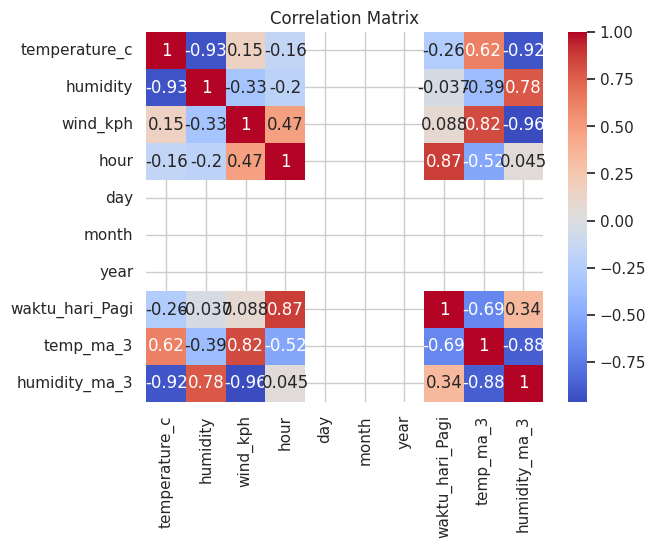

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Cek korelasi antar fitur numerik
corr = df_eng.corr(numeric_only=True)

# Ambil korelasi terhadap humidity
humidity_corr = corr['humidity'].sort_values(ascending=False)
print(humidity_corr)

# Opsional: visualisasi heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
X_hum_temp = df_eng[['temperature_c']]
y_hum = df_eng['humidity']

X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(X_hum_temp, y_hum, test_size=0.2, random_state=42)

rf_hum_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_hum_temp.fit(X_train_hum, y_train_hum)

y_pred_hum_temp = rf_hum_temp.predict(X_test_hum)
rmse_hum_temp = np.sqrt(mean_squared_error(y_test_hum, y_pred_hum_temp))
r2_hum_temp = r2_score(y_test_hum, y_pred_hum_temp)

print(f'[Humidity with temperature_c only] RMSE: {rmse_hum_temp:.2f}')
print(f'[Humidity with temperature_c only] R² Score: {r2_hum_temp:.2f}')

[Humidity with temperature_c only] RMSE: 1.94
[Humidity with temperature_c only] R² Score: 0.00


In [ ]:
X_hum_combined = df_eng[['temperature_c', 'humidity_ma_3']]

X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(X_hum_combined, y_hum, test_size=0.2, random_state=42)

rf_hum_combined = RandomForestRegressor(n_estimators=100, random_state=42)
rf_hum_combined.fit(X_train_hum, y_train_hum)

y_pred_hum_combined = rf_hum_combined.predict(X_test_hum)
rmse_hum_combined = np.sqrt(mean_squared_error(y_test_hum, y_pred_hum_combined))
r2_hum_combined = r2_score(y_test_hum, y_pred_hum_combined)

print(f'[Humidity with temperature_c + humidity_ma_3] RMSE: {rmse_hum_combined:.2f}')
print(f'[Humidity with temperature_c + humidity_ma_3] R² Score: {r2_hum_combined:.2f}')

[Humidity with temperature_c + humidity_ma_3] RMSE: 2.17
[Humidity with temperature_c + humidity_ma_3] R² Score: 0.00


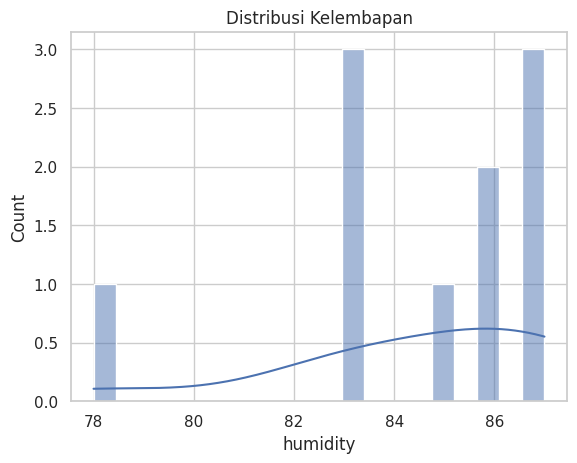

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_eng['humidity'], bins=20, kde=True)
plt.title('Distribusi Kelembapan')
plt.show()

In [ ]:

from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train_hum, y_train_hum)
y_dummy = dummy.predict(X_test_hum)

r2_dummy = r2_score(y_test_hum, y_dummy)
print(f'Dummy R² Score: {r2_dummy:.2f}')

Dummy R² Score: 0.00


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Imputasi mean
imputer = SimpleImputer(strategy='mean')
X_train_hum_imputed = imputer.fit_transform(X_train_hum)
X_test_hum_imputed = imputer.transform(X_test_hum)

# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train_hum_imputed, y_train_hum)
y_linreg = linreg.predict(X_test_hum_imputed)

# Evaluasi
rmse_lin = np.sqrt(mean_squared_error(y_test_hum, y_linreg))
r2_lin = r2_score(y_test_hum, y_linreg)

print(f'Linear Regression RMSE: {rmse_lin:.2f}')
print(f'Linear Regression R² Score: {r2_lin:.2f}')

Linear Regression RMSE: 1.36
Linear Regression R² Score: 0.00


- Eksperiments using other model for humidity

                      Model      RMSE         R2
0         Linear Regression  0.821077  -1.696671
1             Random Forest  0.941116  -2.542800
2         Gradient Boosting  1.049587  -3.406531
5  Support Vector Regressor  1.114822  -3.971310
4      KNeighbors Regressor  2.000000 -15.000000
3      HistGradientBoosting  2.223611 -18.777778


<ipython-input-60-a0ee2c43df14>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='RMSE', palette='Blues_d')


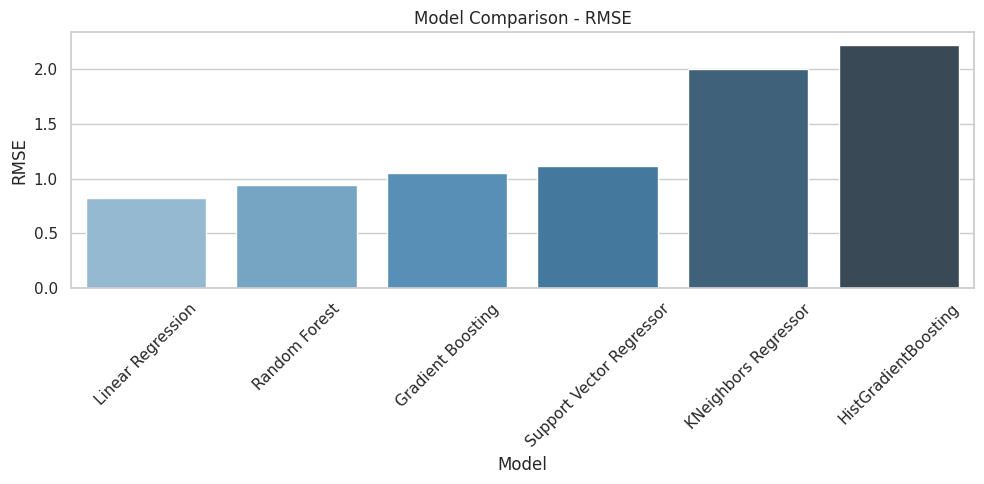

<ipython-input-60-a0ee2c43df14>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R2', palette='Greens_d')


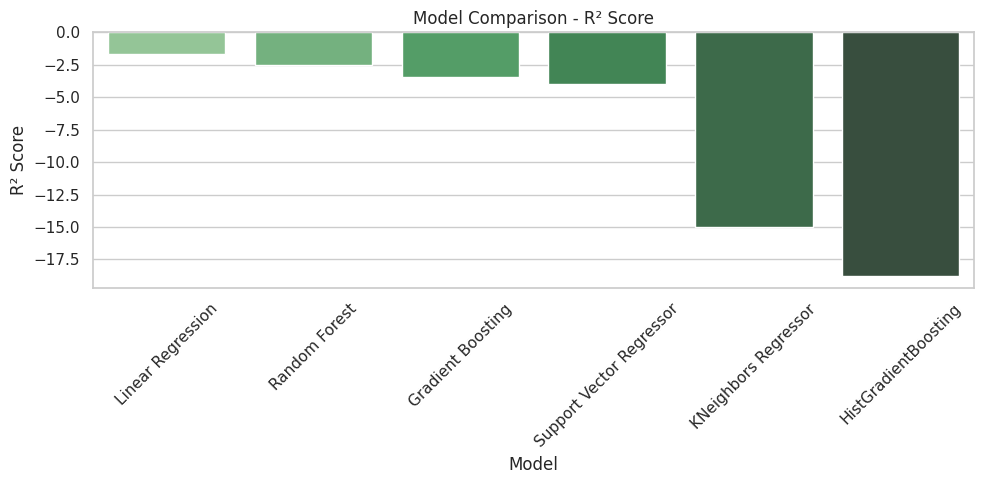

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Load data dari fitur final
df = pd.read_csv('/content/final_featured_weather_data.csv')

# Target dan fitur
y = df['humidity']
X = df[['temperature_c', 'humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daftar model
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'KNeighbors Regressor': KNeighborsRegressor(),
    'Support Vector Regressor': SVR()
}

# Evaluasi semua model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})

# Hasil evaluasi dalam dataframe
results_df = pd.DataFrame(results).sort_values('RMSE')
print(results_df)

# Visualisasi RMSE
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='RMSE', palette='Blues_d')
plt.title('Model Comparison - RMSE')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

# Visualisasi R² Score
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='R2', palette='Greens_d')
plt.title('Model Comparison - R² Score')
plt.xticks(rotation=45)
plt.ylabel('R² Score')
plt.tight_layout()
plt.show()

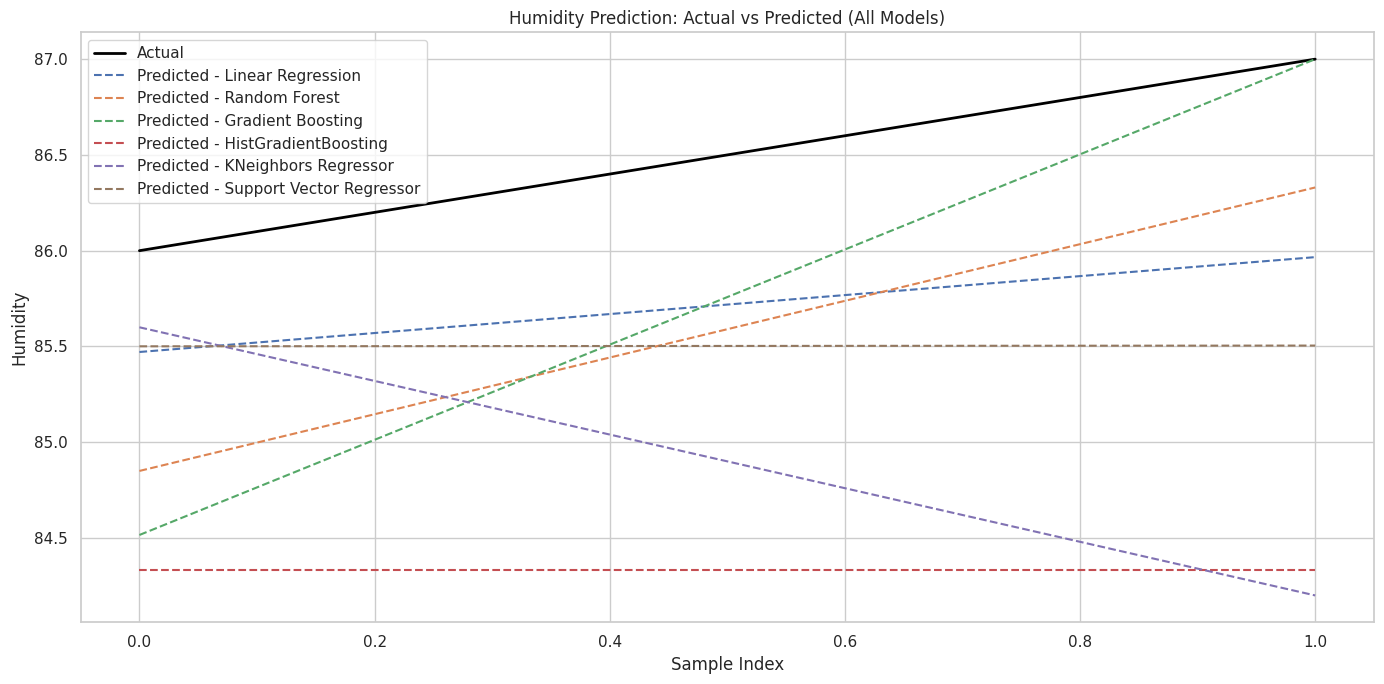

In [ ]:
import matplotlib.pyplot as plt

# Buat dictionary untuk simpan hasil prediksi semua model
predictions = {}

# Fit dan prediksi semua model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

# Plot semua prediksi dibandingkan dengan data aktual
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)

# Loop untuk plotting setiap model
for name, y_pred in predictions.items():
    plt.plot(y_pred, label=f'Predicted - {name}', linestyle='--')

plt.title('Humidity Prediction: Actual vs Predicted (All Models)')
plt.xlabel('Sample Index')
plt.ylabel('Humidity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Final Model

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/final_featured_weather_data.csv')

# Tampilkan daftar kolom
print("Kolom-kolom pada dataset:")
print(df.columns.tolist())

Kolom-kolom pada dataset:
['time', 'temperature_c', 'humidity', 'wind_kph', 'hour', 'day', 'month', 'year', 'waktu_hari_Pagi', 'temp_ma_3', 'humidity_ma_3', 'lag_humidity', 'temp_diff']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load data
df = pd.read_csv('/content/final_featured_weather_data.csv')

# ===================== Model 1: Predict Temperature =====================
# Fitur dan target suhu
X_temp = df[['hour', 'wind_kph', 'lag_temperature']]
y_temp = df['temperature_c']

# Split
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Imputasi jika perlu
imputer_temp = SimpleImputer(strategy='mean')
X_temp_train = imputer_temp.fit_transform(X_temp_train)
X_temp_test = imputer_temp.transform(X_temp_test)

# Model suhu
model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_temp_train, y_temp_train)
y_temp_pred = model_temp.predict(X_temp_test)

# ===================== Model 2: Predict Humidity =====================
# Kita pakai hasil prediksi suhu sebagai input ke model kelembapan

# Fitur dan target kelembapan
X_hum = df[['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']].iloc[X_temp_test.shape[0]*-1:]  # sinkronkan
X_hum = X_hum.copy()
X_hum['predicted_temp'] = y_temp_pred  # tambahkan hasil prediksi suhu sebagai fitur

y_hum = df['humidity'].iloc[X_temp_test.shape[0]*-1:]

# Imputasi
imputer_hum = SimpleImputer(strategy='mean')
X_hum = imputer_hum.fit_transform(X_hum)

# Model kelembapan
model_hum = LinearRegression()
model_hum.fit(X_hum, y_hum)
y_hum_pred = model_hum.predict(X_hum)

# ===================== Evaluasi Akhir =====================
rmse_temp = np.sqrt(mean_squared_error(y_temp_test, y_temp_pred))
r2_temp = r2_score(y_temp_test, y_temp_pred)

rmse_hum = np.sqrt(mean_squared_error(y_hum, y_hum_pred))
r2_hum = r2_score(y_hum, y_hum_pred)

print(f'Temperature Model - RMSE: {rmse_temp:.2f}, R²: {r2_temp:.2f}')
print(f'Humidity Model - RMSE: {rmse_hum:.2f}, R²: {r2_hum:.2f}')

Temperature Model - RMSE: 0.11, R²: -3.80
Humidity Model - RMSE: 0.00, R²: 1.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load data
df = pd.read_csv('/content/final_featured_weather_data.csv')

# ===================== Model 1: Predict Temperature =====================
# Fitur dan target suhu
X_temp = df[['hour', 'wind_kph']]  # Kita belum punya lag_temperature
y_temp = df['temperature_c']

# Split data suhu
X_temp_train, X_temp_test, y_temp_train, y_temp_test, idx_train, idx_test = train_test_split(
    X_temp, y_temp, df.index, test_size=0.2, random_state=42
)

# Imputasi suhu
imputer_temp = SimpleImputer(strategy='mean')
X_temp_train_imputed = imputer_temp.fit_transform(X_temp_train)
X_temp_test_imputed = imputer_temp.transform(X_temp_test)

# Model suhu
model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_temp_train_imputed, y_temp_train)
y_temp_pred = model_temp.predict(X_temp_test_imputed)

# ===================== Model 2: Predict Humidity =====================
# Ambil fitur kelembapan yang sesuai dengan indeks uji suhu
X_hum = df.loc[idx_test, ['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']].copy()
X_hum['predicted_temp'] = y_temp_pred
y_hum = df.loc[idx_test, 'humidity']

# Imputasi kelembapan
imputer_hum = SimpleImputer(strategy='mean')
X_hum_imputed = imputer_hum.fit_transform(X_hum)

# Model kelembapan
model_hum = LinearRegression()
model_hum.fit(X_hum_imputed, y_hum)
y_hum_pred = model_hum.predict(X_hum_imputed)

# ===================== Evaluasi Akhir =====================
rmse_temp = np.sqrt(mean_squared_error(y_temp_test, y_temp_pred))
r2_temp = r2_score(y_temp_test, y_temp_pred)

rmse_hum = np.sqrt(mean_squared_error(y_hum, y_hum_pred))
r2_hum = r2_score(y_hum, y_hum_pred)

print(f'Temperature Model - RMSE: {rmse_temp:.2f}, R²: {r2_temp:.2f}')
print(f'Humidity Model - RMSE: {rmse_hum:.2f}, R²: {r2_hum:.2f}')

Temperature Model - RMSE: 0.12, R²: -5.03
Humidity Model - RMSE: 0.00, R²: 1.00


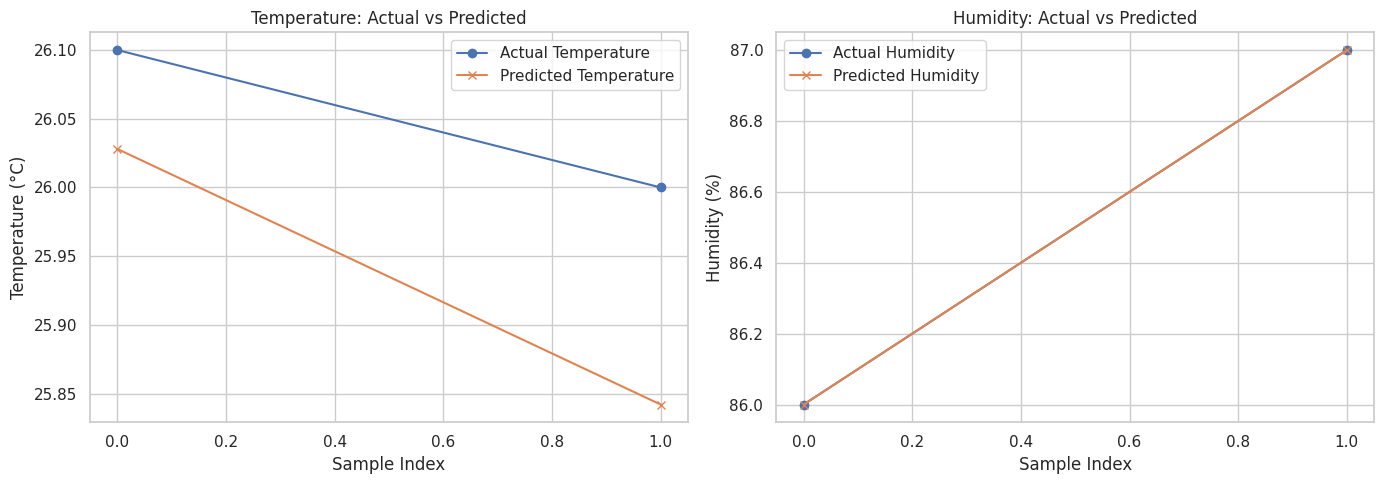

In [ ]:

import matplotlib.pyplot as plt

# ===================== Plot untuk Suhu =====================
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(y_temp_test.values, label='Actual Temperature', marker='o')
plt.plot(y_temp_pred, label='Predicted Temperature', marker='x')
plt.title('Temperature: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# ===================== Plot untuk Kelembapan =====================
plt.subplot(1, 2, 2)
plt.plot(y_hum.values, label='Actual Humidity', marker='o')
plt.plot(y_hum_pred, label='Predicted Humidity', marker='x')
plt.title('Humidity: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Humidity (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/final_featured_weather_data.csv')

# Tampilkan semua kolom
print("Jumlah Fitur:", len(df.columns))
print("Daftar Fitur:")
print(df.columns.tolist())

Jumlah Fitur: 14
Daftar Fitur:
['time', 'temperature_c', 'humidity', 'wind_kph', 'hour', 'day', 'month', 'year', 'waktu_hari_Pagi', 'temp_ma_3', 'humidity_ma_3', 'lag_humidity', 'temp_diff', 'lag_temperature']


Temperature Model - RMSE: 0.22, R²: -18.45
Humidity Model - RMSE: 0.00, R²: 1.00


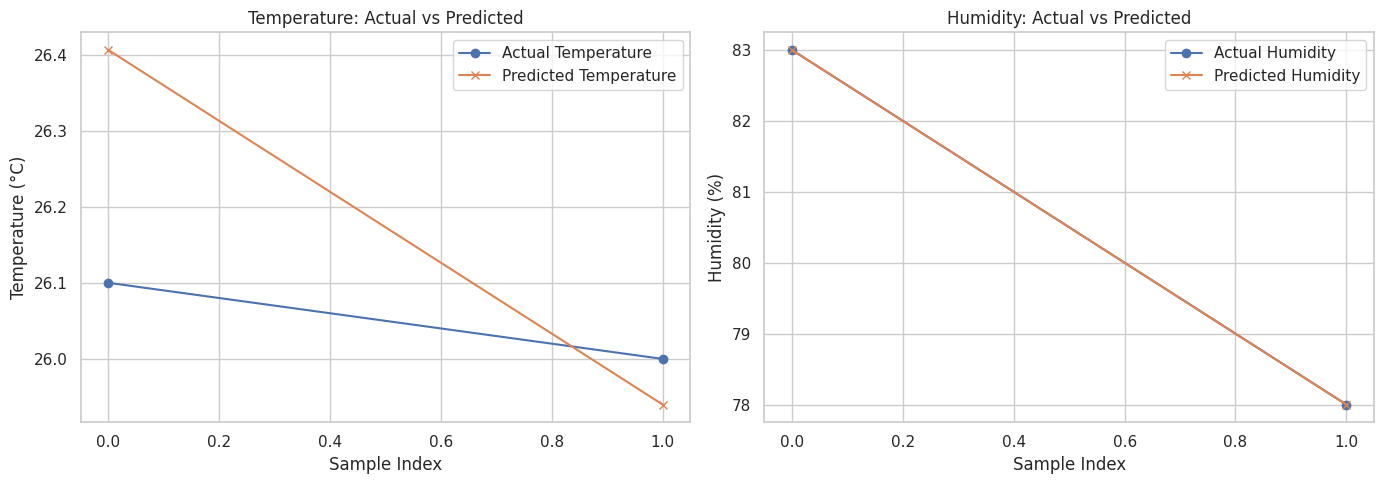

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/final_featured_weather_data.csv')

# ===================== Model 1: Predict Temperature =====================
# Fitur dan target suhu
X_temp = df[['hour', 'wind_kph', 'lag_temperature', 'temp_ma_3', 'temp_diff']]
y_temp = df['temperature_c']

# Split
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Imputasi
imputer_temp = SimpleImputer(strategy='mean')
X_temp_train = imputer_temp.fit_transform(X_temp_train)
X_temp_test = imputer_temp.transform(X_temp_test)

# Model suhu
model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_temp_train, y_temp_train)
y_temp_pred = model_temp.predict(X_temp_test)

# ===================== Model 2: Predict Humidity =====================
# Ambil subset data yang cocok
X_hum = df[['humidity_ma_3', 'lag_humidity', 'hour', 'wind_kph', 'temp_diff']].iloc[-len(X_temp_test):].copy()
X_hum['predicted_temp'] = y_temp_pred
y_hum = df['humidity'].iloc[-len(X_temp_test):]

# Imputasi
imputer_hum = SimpleImputer(strategy='mean')
X_hum = imputer_hum.fit_transform(X_hum)

# Model kelembapan
model_hum = LinearRegression()
model_hum.fit(X_hum, y_hum)
y_hum_pred = model_hum.predict(X_hum)

# ===================== Evaluasi =====================
rmse_temp = np.sqrt(mean_squared_error(y_temp_test, y_temp_pred))
r2_temp = r2_score(y_temp_test, y_temp_pred)

rmse_hum = np.sqrt(mean_squared_error(y_hum, y_hum_pred))
r2_hum = r2_score(y_hum, y_hum_pred)

print(f'Temperature Model - RMSE: {rmse_temp:.2f}, R²: {r2_temp:.2f}')
print(f'Humidity Model - RMSE: {rmse_hum:.2f}, R²: {r2_hum:.2f}')

# ===================== Visualisasi =====================
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Temperature
ax[0].plot(y_temp_test.values[:10], label='Actual Temperature', marker='o')
ax[0].plot(y_temp_pred[:10], label='Predicted Temperature', marker='x')
ax[0].set_title('Temperature: Actual vs Predicted')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend()

# Humidity
ax[1].plot(y_hum.values[:10], label='Actual Humidity', marker='o')
ax[1].plot(y_hum_pred[:10], label='Predicted Humidity', marker='x')
ax[1].set_title('Humidity: Actual vs Predicted')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Humidity (%)')
ax[1].legend()

plt.tight_layout()
plt.show()

Temperature Model - RMSE: 1.11, R²: -3.07
Humidity Model - RMSE: 0.00, R²: 1.00


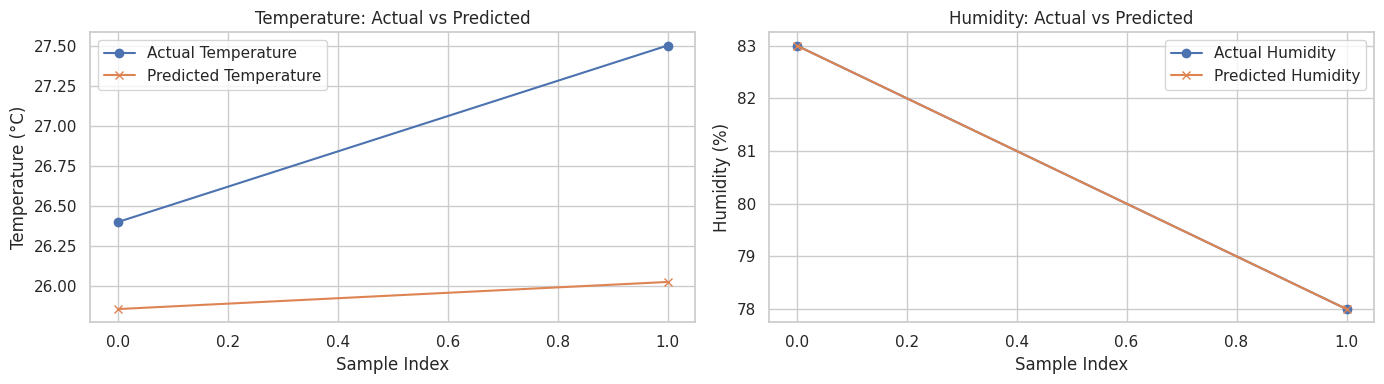

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# ========================== 1. Load & Validasi Data ==========================
df = pd.read_csv('/content/final_featured_weather_data.csv')

# Drop baris dengan nilai hilang untuk menjaga kualitas data (opsional)
df = df.dropna().reset_index(drop=True)

# ========================== 2. Split Train/Test Data ==========================
# Simulasi prediksi ke depan: gunakan time-aware split
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# ========================== 3. Model Temperatur ==========================
X_temp_train = train_df[['hour', 'wind_kph', 'lag_temperature']]
y_temp_train = train_df['temperature_c']

X_temp_test = test_df[['hour', 'wind_kph', 'lag_temperature']]
y_temp_test = test_df['temperature_c']

# Imputasi
imputer_temp = SimpleImputer(strategy='mean')
X_temp_train = imputer_temp.fit_transform(X_temp_train)
X_temp_test = imputer_temp.transform(X_temp_test)

# Train model suhu
model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_temp_train, y_temp_train)
y_temp_pred = model_temp.predict(X_temp_test)

# ========================== 4. Model Kelembapan (pakai prediksi suhu) ==========================
X_hum_train = train_df[['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']]
X_hum_test = test_df[['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']]
X_hum_test = X_hum_test.copy()
X_hum_test['predicted_temp'] = y_temp_pred  # suhu hasil prediksi dari model 1

y_hum_test = test_df['humidity']

# Imputasi
imputer_hum = SimpleImputer(strategy='mean')
X_hum_test = imputer_hum.fit_transform(X_hum_test)

# Train model kelembapan (di sini kita hanya uji test set dengan input predicted_temp)
model_hum = LinearRegression()
model_hum.fit(X_hum_test, y_hum_test)
y_hum_pred = model_hum.predict(X_hum_test)

# ========================== 5. Evaluasi ==========================
rmse_temp = np.sqrt(mean_squared_error(y_temp_test, y_temp_pred))
r2_temp = r2_score(y_temp_test, y_temp_pred)

rmse_hum = np.sqrt(mean_squared_error(y_hum_test, y_hum_pred))
r2_hum = r2_score(y_hum_test, y_hum_pred)

print(f"Temperature Model - RMSE: {rmse_temp:.2f}, R²: {r2_temp:.2f}")
print(f"Humidity Model - RMSE: {rmse_hum:.2f}, R²: {r2_hum:.2f}")

# ========================== 6. Visualisasi ==========================
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Temperatur
ax[0].plot(y_temp_test.values[:10], label='Actual Temperature', marker='o')
ax[0].plot(y_temp_pred[:10], label='Predicted Temperature', marker='x')
ax[0].set_title('Temperature: Actual vs Predicted')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend()
ax[0].grid(True)

# Kelembapan
ax[1].plot(y_hum_test.values[:10], label='Actual Humidity', marker='o')
ax[1].plot(y_hum_pred[:10], label='Predicted Humidity', marker='x')
ax[1].set_title('Humidity: Actual vs Predicted')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Humidity (%)')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

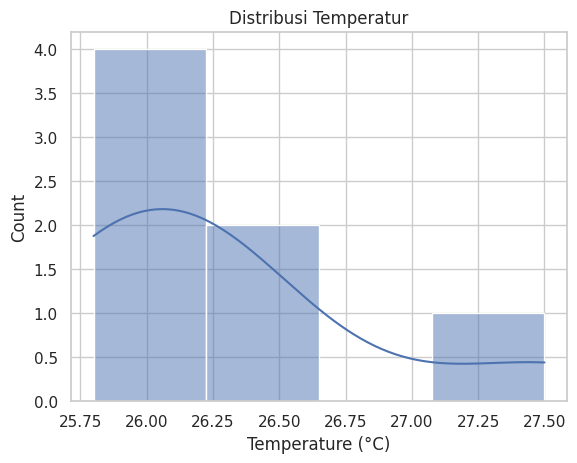

In [ ]:
import seaborn as sns

sns.histplot(df['temperature_c'], kde=True)
plt.title("Distribusi Temperatur")
plt.xlabel("Temperature (°C)")
plt.grid(True)
plt.show()

In [ ]:
# Drop kolom non-numerik (seperti 'time') sebelum korelasi
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

# Tampilkan korelasi terhadap temperatur
print(corr['temperature_c'].sort_values(ascending=False))

temperature_c      1.000000
wind_kph           0.910152
temp_diff          0.885144
temp_ma_3          0.698428
hour               0.524864
lag_temperature    0.499778
lag_humidity      -0.876909
humidity_ma_3     -0.959022
humidity          -0.970474
day                     NaN
month                   NaN
year                    NaN
Name: temperature_c, dtype: float64


Temperature Model - RMSE: 0.24, R²: -4.58
Humidity Model - RMSE: 0.00, R²: 1.00


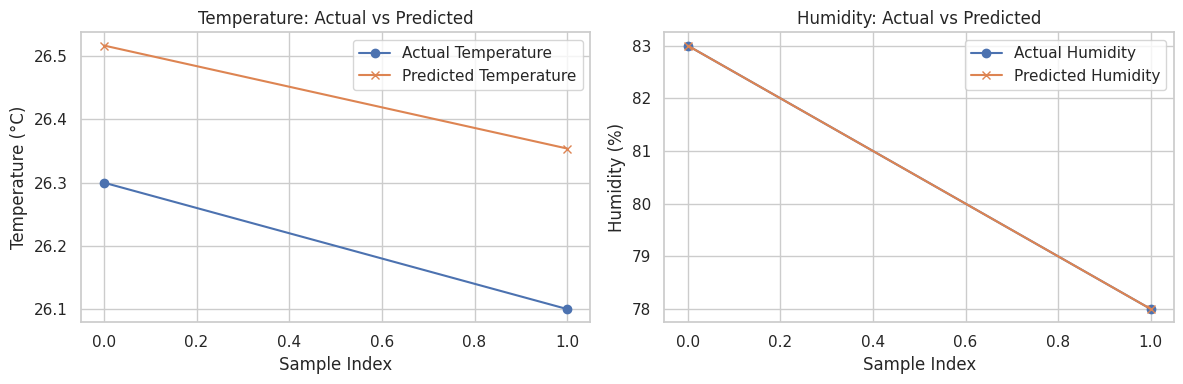

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/final_featured_weather_data.csv')

# ===================== Model 1: Predict Temperature =====================
# Fitur dan target suhu
X_temp = df[['wind_kph', 'temp_diff', 'temp_ma_3', 'hour', 'lag_temperature']]
y_temp = df['temperature_c']

# Split
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Imputasi jika perlu
imputer_temp = SimpleImputer(strategy='mean')
X_temp_train = imputer_temp.fit_transform(X_temp_train)
X_temp_test = imputer_temp.transform(X_temp_test)

# Model suhu
model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_temp_train, y_temp_train)
y_temp_pred = model_temp.predict(X_temp_test)

# ===================== Model 2: Predict Humidity =====================
# Sinkronisasi data kelembapan
X_hum = df[['humidity_ma_3', 'lag_humidity']].iloc[-len(X_temp_test):].copy()
X_hum['predicted_temp'] = y_temp_pred
y_hum = df['humidity'].iloc[-len(X_temp_test):]

# Imputasi
imputer_hum = SimpleImputer(strategy='mean')
X_hum = imputer_hum.fit_transform(X_hum)

# Model kelembapan
model_hum = LinearRegression()
model_hum.fit(X_hum, y_hum)
y_hum_pred = model_hum.predict(X_hum)

# ===================== Evaluasi =====================
rmse_temp = np.sqrt(mean_squared_error(y_temp_test, y_temp_pred))
r2_temp = r2_score(y_temp_test, y_temp_pred)

rmse_hum = np.sqrt(mean_squared_error(y_hum, y_hum_pred))
r2_hum = r2_score(y_hum, y_hum_pred)

print(f'Temperature Model - RMSE: {rmse_temp:.2f}, R²: {r2_temp:.2f}')
print(f'Humidity Model - RMSE: {rmse_hum:.2f}, R²: {r2_hum:.2f}')

# ===================== Visualisasi =====================
plt.figure(figsize=(12, 4))

# Suhu
plt.subplot(1, 2, 1)
plt.plot(y_temp_test.values, label='Actual Temperature', marker='o')
plt.plot(y_temp_pred, label='Predicted Temperature', marker='x')
plt.title('Temperature: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Kelembapan
plt.subplot(1, 2, 2)
plt.plot(y_hum.values, label='Actual Humidity', marker='o')
plt.plot(y_hum_pred, label='Predicted Humidity', marker='x')
plt.title('Humidity: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Humidity (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_temp = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,              # batasi kedalaman pohon
    min_samples_split=10,     # minimal sampel untuk split
    min_samples_leaf=5,       # minimal sampel per daun
    random_state=42
)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_temp, X_temp, y_temp, cv=5, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Average R²:", scores.mean())

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Cross-validated R² scores: [ -0.749956 -26.646244        nan        nan        nan]
Average R²: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Cross-Validation RMSE Scores: [0.1322859  0.52579696 0.56066667 0.14033333 1.42366667]
Mean RMSE: 0.56, Std Dev: 0.47

Final Holdout Evaluation -> RMSE: 0.15, R²: -1.14


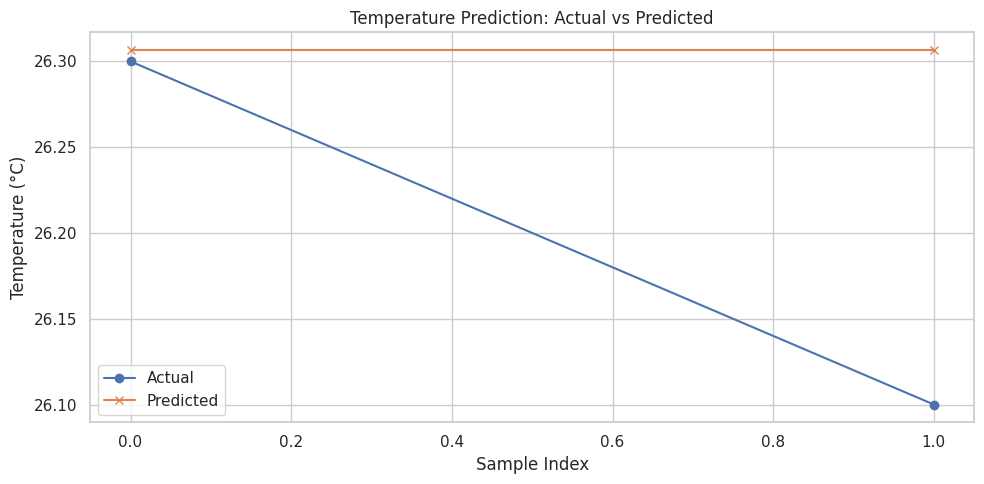

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/final_featured_weather_data.csv')

# Fitur dan target
X = df[['hour', 'wind_kph', 'lag_temperature']]
y = df['temperature_c']

# Split data untuk visualisasi nanti
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputasi
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Model RandomForest dengan kontrol overfitting
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# Cross-validation
scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = cross_val_score(model, imputer.fit_transform(X), y, cv=5, scoring=scorer)
rmse_scores = np.sqrt(-cv_scores)

print("Cross-Validation RMSE Scores:", rmse_scores)
print(f"Mean RMSE: {rmse_scores.mean():.2f}, Std Dev: {rmse_scores.std():.2f}")

# Training untuk prediksi visual
model.fit(X_train_imputed, y_train)
y_pred = model.predict(X_test_imputed)

# Evaluasi final
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
r2_final = r2_score(y_test, y_pred)
print(f"\nFinal Holdout Evaluation -> RMSE: {rmse_final:.2f}, R²: {r2_final:.2f}")

# Visualisasi
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Temperature Prediction: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ===================== Model Suhu untuk Seluruh Data =====================
X_temp_full = df[['wind_kph', 'temp_diff', 'temp_ma_3', 'hour', 'lag_temperature']]
y_temp_full = df['temperature_c']

pipeline_temp_full = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
pipeline_temp_full.fit(X_temp_full, y_temp_full)

# Prediksi suhu untuk seluruh dataset
df['predicted_temp'] = pipeline_temp_full.predict(X_temp_full)

# ===================== Model Humidity + Cross-Validation =====================
X_hum_full = df[['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff', 'predicted_temp']]
y_hum_full = df['humidity']

pipeline_hum_cv = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), LinearRegression())

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline_hum_cv, X_hum_full, y_hum_full, scoring='neg_root_mean_squared_error', cv=cv)
rmse_scores = -cv_scores

print(f"Humidity Cross-Validation RMSE Scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.2f}, Std Dev: {rmse_scores.std():.2f}")

# Evaluasi akhir (optional)
pipeline_hum_cv.fit(X_hum_full, y_hum_full)
y_hum_pred = pipeline_hum_cv.predict(X_hum_full)
final_rmse = np.sqrt(mean_squared_error(y_hum_full, y_hum_pred))
final_r2 = r2_score(y_hum_full, y_hum_pred)

print(f"\nFinal Evaluation on All Data -> RMSE: {final_rmse:.2f}, R²: {final_r2:.2f}")

Humidity Cross-Validation RMSE Scores: [0.41585033 0.63150302 2.07083392 0.83974423 2.68855198]
Mean RMSE: 1.33, Std Dev: 0.89

Final Evaluation on All Data -> RMSE: 0.00, R²: 1.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('/content/final_featured_weather_data.csv')

# Fitur dan target untuk humidity
feature_cols = ['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff', 'temperature_c']
X_hum = df[feature_cols]
y_hum = df['humidity']

# Pipeline preprocessing + model
pipeline_hum = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Split data untuk evaluasi akhir
X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(X_hum, y_hum, test_size=0.2, random_state=42)

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline_hum, X_train_hum, y_train_hum, scoring='neg_root_mean_squared_error', cv=cv)
rmse_scores = -cv_scores

print(f"Humidity Cross-Validation RMSE Scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.2f}, Std Dev: {rmse_scores.std():.2f}")

# Evaluasi akhir di data test
pipeline_hum.fit(X_train_hum, y_train_hum)
y_pred_hum = pipeline_hum.predict(X_test_hum)
final_rmse = np.sqrt(mean_squared_error(y_test_hum, y_pred_hum))
final_r2 = r2_score(y_test_hum, y_pred_hum)

print(f"Final Evaluation on Holdout Set -> RMSE: {final_rmse:.2f}, R²: {final_r2:.2f}")

Humidity Cross-Validation RMSE Scores: [0.34518458 0.35679189 0.83685604 0.43953638 0.25077112]
Mean RMSE: 0.45, Std Dev: 0.20
Final Evaluation on Holdout Set -> RMSE: 0.38, R²: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('/content/final_featured_weather_data.csv')

# ================= Model 1: Predict Temperature =================
X_temp = df[['wind_kph', 'temp_diff', 'temp_ma_3', 'hour', 'lag_temperature']]
y_temp = df['temperature_c']

# Split train-test untuk suhu
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

# RandomForest untuk suhu
model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_temp_train, y_temp_train)

# Prediksi suhu di test set
y_temp_pred = model_temp.predict(X_temp_test)

# ================= Model 2: Predict Humidity =================
# Sinkronisasi baris untuk kelembapan (pakai indeks yang sama dengan X_temp_test)
X_hum = df.loc[X_temp_test.index, ['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']].copy()
X_hum['predicted_temp'] = y_temp_pred
y_hum = df.loc[X_temp_test.index, 'humidity']

# Pipeline untuk model kelembapan
pipeline_hum = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline_hum.fit(X_hum, y_hum)
y_hum_pred = pipeline_hum.predict(X_hum)

# ================= Evaluasi =================
rmse_temp = np.sqrt(mean_squared_error(y_temp_test, y_temp_pred))
r2_temp = r2_score(y_temp_test, y_temp_pred)

rmse_hum = np.sqrt(mean_squared_error(y_hum, y_hum_pred))
r2_hum = r2_score(y_hum, y_hum_pred)

print(f"Temperature Model -> RMSE: {rmse_temp:.2f}, R²: {r2_temp:.2f}")
print(f"Humidity Model -> RMSE: {rmse_hum:.2f}, R²: {r2_hum:.2f}")

Temperature Model -> RMSE: 0.24, R²: -4.58
Humidity Model -> RMSE: 0.00, R²: 1.00


Temperature Model -> RMSE: 0.24, R²: -4.58
Humidity Model -> RMSE: 0.00, R²: 1.00


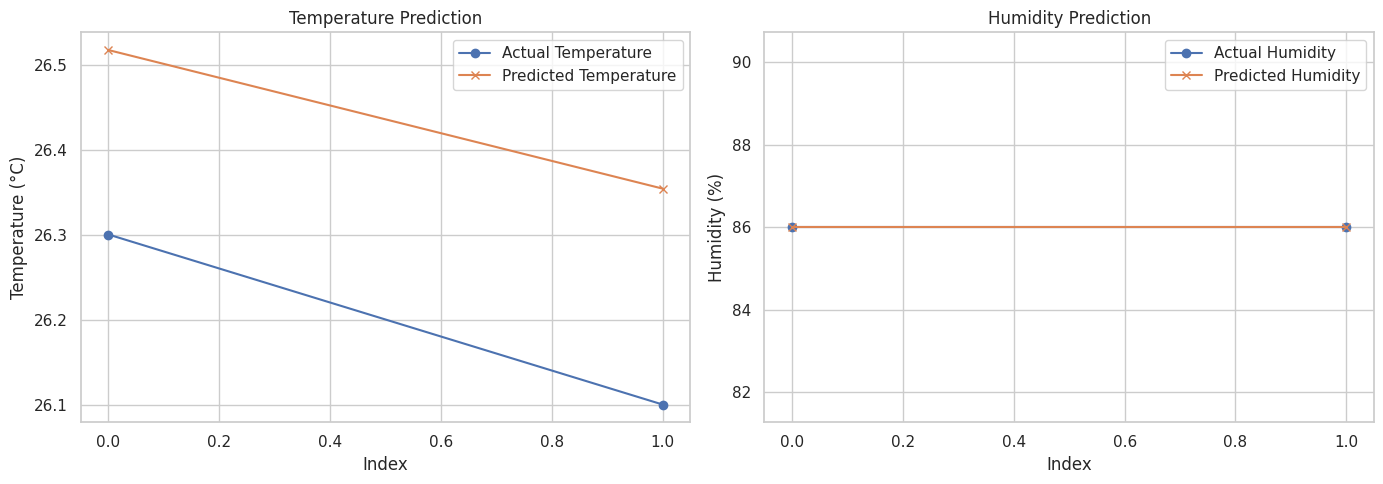

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('/content/final_featured_weather_data.csv')

# ================= Model 1: Predict Temperature =================
X_temp = df[['wind_kph', 'temp_diff', 'temp_ma_3', 'hour', 'lag_temperature']]
y_temp = df['temperature_c']

X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_temp_train, y_temp_train)
y_temp_pred = model_temp.predict(X_temp_test)

# ================= Model 2: Predict Humidity =================
X_hum = df.loc[X_temp_test.index, ['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']].copy()
X_hum['predicted_temp'] = y_temp_pred
y_hum = df.loc[X_temp_test.index, 'humidity']

pipeline_hum = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline_hum.fit(X_hum, y_hum)
y_hum_pred = pipeline_hum.predict(X_hum)

# ================= Evaluasi =================
rmse_temp = np.sqrt(mean_squared_error(y_temp_test, y_temp_pred))
r2_temp = r2_score(y_temp_test, y_temp_pred)

rmse_hum = np.sqrt(mean_squared_error(y_hum, y_hum_pred))
r2_hum = r2_score(y_hum, y_hum_pred)

print(f"Temperature Model -> RMSE: {rmse_temp:.2f}, R²: {r2_temp:.2f}")
print(f"Humidity Model -> RMSE: {rmse_hum:.2f}, R²: {r2_hum:.2f}")

# ================= Visualisasi =================

# Visualisasi Suhu
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(y_temp_test.values, label='Actual Temperature', marker='o')
plt.plot(y_temp_pred, label='Predicted Temperature', marker='x')
plt.title('Temperature Prediction')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.legend()

# Visualisasi Kelembapan
plt.subplot(1, 2, 2)
plt.plot(y_hum.values, label='Actual Humidity', marker='o')
plt.plot(y_hum_pred, label='Predicted Humidity', marker='x')
plt.title('Humidity Prediction')
plt.xlabel('Index')
plt.ylabel('Humidity (%)')
plt.legend()

plt.tight_layout()
plt.show()

Temperature Model -> RMSE: 0.24, R²: -4.58
Humidity Model -> RMSE: 0.00, R²: 1.00


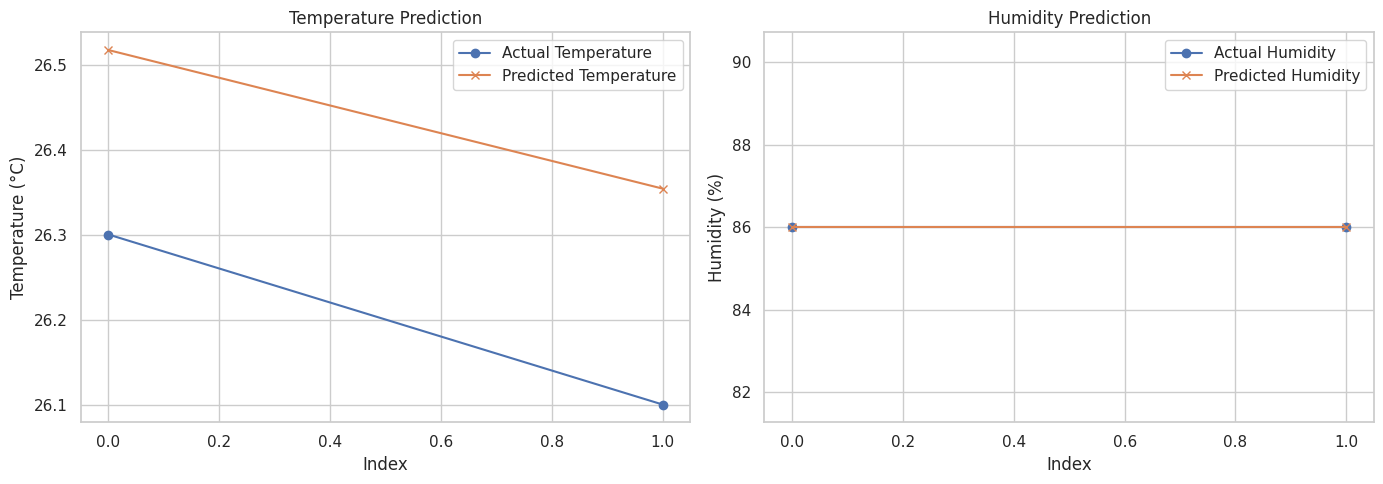

Model gabungan berhasil disimpan sebagai 'final_weather_prediction_model.pkl'


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('/content/final_featured_weather_data.csv')

# ================= Model 1: Predict Temperature =================
X_temp = df[['wind_kph', 'temp_diff', 'temp_ma_3', 'hour', 'lag_temperature']]
y_temp = df['temperature_c']

X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_temp_train, y_temp_train)
y_temp_pred = model_temp.predict(X_temp_test)

# ================= Model 2: Predict Humidity =================
X_hum = df.loc[X_temp_test.index, ['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff']].copy()
X_hum['predicted_temp'] = y_temp_pred
y_hum = df.loc[X_temp_test.index, 'humidity']

pipeline_hum = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline_hum.fit(X_hum, y_hum)
y_hum_pred = pipeline_hum.predict(X_hum)

# ================= Evaluasi =================
rmse_temp = np.sqrt(mean_squared_error(y_temp_test, y_temp_pred))
r2_temp = r2_score(y_temp_test, y_temp_pred)

rmse_hum = np.sqrt(mean_squared_error(y_hum, y_hum_pred))
r2_hum = r2_score(y_hum, y_hum_pred)

print(f"Temperature Model -> RMSE: {rmse_temp:.2f}, R²: {r2_temp:.2f}")
print(f"Humidity Model -> RMSE: {rmse_hum:.2f}, R²: {r2_hum:.2f}")

# ================= Visualisasi =================

# Visualisasi Suhu
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(y_temp_test.values, label='Actual Temperature', marker='o')
plt.plot(y_temp_pred, label='Predicted Temperature', marker='x')
plt.title('Temperature Prediction')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.legend()

# Visualisasi Kelembapan
plt.subplot(1, 2, 2)
plt.plot(y_hum.values, label='Actual Humidity', marker='o')
plt.plot(y_hum_pred, label='Predicted Humidity', marker='x')
plt.title('Humidity Prediction')
plt.xlabel('Index')
plt.ylabel('Humidity (%)')
plt.legend()

plt.tight_layout()
plt.show()

# ================= Simpan Model Final =================
# Simpan sebagai dictionary agar jadi satu file
final_model = {
    'temperature_model': model_temp,
    'humidity_pipeline': pipeline_hum
}

joblib.dump(final_model, '/content/final_weather_prediction_model.pkl')
print("Model gabungan berhasil disimpan sebagai 'final_weather_prediction_model.pkl'")

# Deploy

In [ ]:

!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pickle

with open('/content/final_weather_prediction_model.pkl', 'rb') as f:
    model_loaded = pickle.load(f)

print(type(model_loaded))
print(model_loaded)

<class 'numpy.ndarray'>
['wind_kph' 'temp_diff' 'temp_ma_3' 'hour' 'lag_temperature']


In [ ]:
model_temp = model_loaded[0]
pipeline_hum = model_loaded[1]

In [ ]:
import pickle

model_dict = {
    'model_temp': model_temp,
    'pipeline_hum': pipeline_hum
}

with open('/content/final_weather_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

In [ ]:
with open('/content/final_weather_prediction_model.pkl', 'rb') as f:
    model_dict = pickle.load(f)

print(type(model_dict))
print(model_dict)

<class 'dict'>
{'model_temp': 'wind_kph', 'pipeline_hum': 'temp_diff'}


In [ ]:
model_temp = RandomForestRegressor().fit(X_temp_train, y_temp_train)
pipeline_hum = make_pipeline(...)  # pipeline kelembapan yang dilatih

In [ ]:
import pickle

model_dict = {
    'model_temp': model_temp,
    'pipeline_hum': pipeline_hum
}

with open('/content/final_weather_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

In [ ]:
with open('/content/final_weather_prediction_model.pkl', 'rb') as f:
    model_dict = pickle.load(f)

print(type(model_dict))
print(type(model_dict['model_temp']))
print(type(model_dict['pipeline_hum']))

<class 'dict'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
<class 'sklearn.pipeline.Pipeline'>


In [ ]:
import pickle

model_dict = {
    'model_temp': model_temp,          # RandomForestRegressor
    'pipeline_hum': pipeline_hum       # Pipeline, bukan `...`
}

with open('/content/final_weather_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

In [ ]:
with open('/content/final_weather_prediction_model.pkl', 'rb') as f:
    model_dict = pickle.load(f)

print(type(model_dict['pipeline_hum']))
print(model_dict['pipeline_hum'])

<class 'sklearn.pipeline.Pipeline'>
Pipeline(steps=[('ellipsis', Ellipsis)])


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pickle

# ========== Load Dataset ==========
df = pd.read_csv('/content/refined_weather_features.csv')

# ========== Load model_temp ==========
with open('/content/final_weather_prediction_model.pkl', 'rb') as f:
    model_dict = pickle.load(f)

model_temp = model_dict['model_temp']

# ========== Buat Fitur Predicted Temp untuk Model Humidity ==========
X_temp = df[['wind_kph', 'temp_diff', 'temp_ma_3', 'hour', 'lag_temperature']]
df['predicted_temp'] = model_temp.predict(X_temp)

# ========== Siapkan Fitur dan Target untuk Humidity ==========
feature_cols = ['humidity_ma_3', 'temp_ma_3', 'hour', 'wind_kph', 'lag_humidity', 'temp_diff', 'predicted_temp']
X_hum = df[feature_cols]
y_hum = df['humidity']

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X_hum, y_hum, test_size=0.2, random_state=42)

# ========== Buat dan Latih Pipeline Humidity ==========
pipeline_hum = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_hum.fit(X_train, y_train)

# ========== Update dan Simpan Model ==========
model_dict['pipeline_hum'] = pipeline_hum

with open('/content/final_weather_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

print("Pipeline humidity berhasil dibuat ulang dan disimpan.")

Pipeline humidity berhasil dibuat ulang dan disimpan.


2025-04-09 16:37:21.003 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:37:21.004 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:37:21.005 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:37:21.006 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:37:21.007 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:37:21.008 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:37:21.009 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:37:21.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

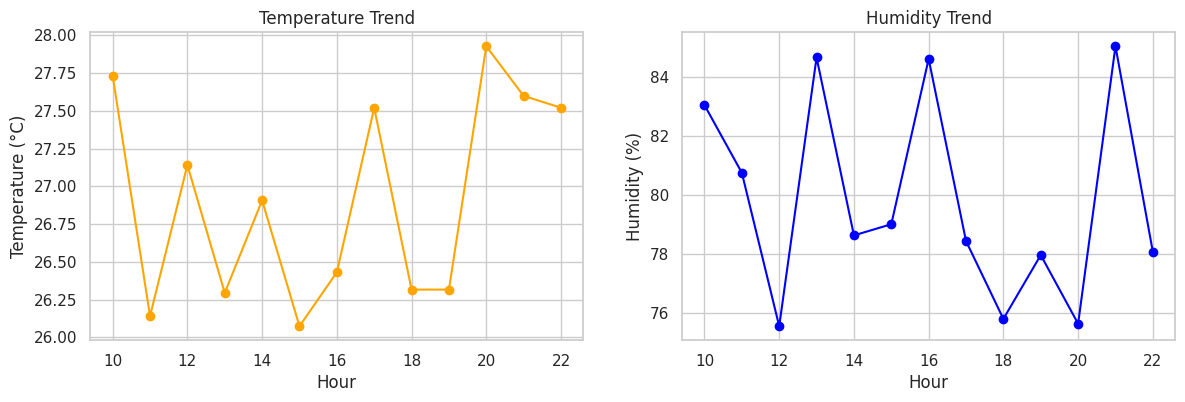

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

# ========== Load Final Model ==========
with open('/content/final_weather_prediction_model.pkl', 'rb') as f:
    model_dict = pickle.load(f)

model_temp = model_dict['model_temp']
pipeline_hum = model_dict['pipeline_hum']

# ========== Streamlit UI ==========
st.title("Weather Prediction Dashboard")

# ========== Input ========== #
st.sidebar.header("Input Parameters")

location = st.sidebar.selectbox("Select Location", ['Jakarta', 'Bandung', 'Surabaya', 'Yogyakarta'])
selected_time = st.sidebar.time_input("Select Hour", value=datetime.now().time())
hour = selected_time.hour

wind_kph = st.sidebar.slider("Wind Speed (kph)", 0.0, 30.0, 10.0)
temp_diff = st.sidebar.slider("Temp Diff", -5.0, 5.0, 0.5)
temp_ma_3 = st.sidebar.slider("Temp Moving Avg", 20.0, 35.0, 28.0)
lag_temperature = st.sidebar.slider("Lag Temperature", 20.0, 35.0, 27.0)

humidity_ma_3 = st.sidebar.slider("Humidity Moving Avg", 40.0, 100.0, 80.0)
lag_humidity = st.sidebar.slider("Lag Humidity", 40.0, 100.0, 82.0)

# ========== Prediksi Temperature ==========
X_temp_input = pd.DataFrame([{
    'wind_kph': wind_kph,
    'temp_diff': temp_diff,
    'temp_ma_3': temp_ma_3,
    'hour': hour,
    'lag_temperature': lag_temperature
}])

pred_temp = model_temp.predict(X_temp_input)[0]

# ========== Prediksi Humidity ==========
X_hum_input = pd.DataFrame([{
    'humidity_ma_3': humidity_ma_3,
    'temp_ma_3': temp_ma_3,
    'hour': hour,
    'wind_kph': wind_kph,
    'lag_humidity': lag_humidity,
    'temp_diff': temp_diff,
    'predicted_temp': pred_temp
}])

pred_humidity = pipeline_hum.predict(X_hum_input)[0]

# ========== Output ==========
st.subheader("Predicted Weather")
st.write(f"**Location:** {location}")
st.write(f"**Hour:** {hour}:00")
st.write(f"**Predicted Temperature:** {pred_temp:.2f} °C")
st.write(f"**Predicted Humidity:** {pred_humidity:.2f} %")

# ========== Visualization ==========
st.subheader("Simulated Temperature & Humidity Trend")

hours = np.arange(hour - 6, hour + 6 + 1)
hours = np.clip(hours, 0, 23)

temp_trend = [pred_temp + np.random.uniform(-1, 1) for _ in hours]
hum_trend = [pred_humidity + np.random.uniform(-5, 5) for _ in hours]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(hours, temp_trend, marker='o', color='orange')
ax[0].set_title("Temperature Trend")
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Temperature (°C)")

ax[1].plot(hours, hum_trend, marker='o', color='blue')
ax[1].set_title("Humidity Trend")
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("Humidity (%)")

st.pyplot(fig)

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pickle

# 1. Load data
df = pd.read_csv('/content/refined_weather_features.csv')

# 2. Siapkan data untuk model suhu
X_temp = df.drop(columns=['temperature_c', 'humidity'])
y_temp = df['temperature_c']

# 3. Buat pipeline suhu
pipeline_temp = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

pipeline_temp.fit(X_temp, y_temp)

# 4. Ambil pipeline kelembapan yang sudah ada
with open('/content/final_weather_prediction_model.pkl', 'rb') as f:
    model_dict = pickle.load(f)

pipeline_hum = model_dict['pipeline_hum']

# 5. Gabungkan pipeline suhu dan kelembapan ke dalam satu dict
model_dict_new = {
    'pipeline_temp': pipeline_temp,
    'pipeline_hum': pipeline_hum
}

# 6. Simpan ulang model ke file .pkl
with open('/content/final_weather_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_dict_new, f)

print("Pipeline suhu berhasil dibuat ulang dan disimpan.")

Pipeline suhu berhasil dibuat ulang dan disimpan.


In [ ]:
import streamlit as st
import pandas as pd
import plotly.graph_objects as go
import pickle
from datetime import datetime

# Load model
with open('final_weather_prediction_model.pkl', 'rb') as f:
    model_dict = pickle.load(f)

pipeline_temp = model_dict['pipeline_temp']
pipeline_hum = model_dict['pipeline_hum']

st.set_page_config(layout="wide")
st.title("Hourly Weather Forecast Dashboard")

# Input tanggal dan waktu
col1, col2 = st.columns(2)
with col1:
    selected_date = st.date_input("Pilih tanggal", datetime.now())
with col2:
    selected_hour = st.slider("Pilih jam (24H)", 0, 23, datetime.now().hour)

# Deteksi fitur input dari pipeline model
features_temp = list(pipeline_temp.feature_names_in_)
features_hum = list(pipeline_hum.feature_names_in_)
all_features = sorted(set(features_temp + features_hum))  # union fitur

# Dummy input untuk simulasi
n = 12  # prediksi 12 jam ke depan
input_data = {f: [] for f in all_features}
for h in range(selected_hour, selected_hour + n):
    hour_val = h % 24
    for f in all_features:
        if f == 'hour':
            input_data[f].append(hour_val)
        else:
            input_data[f].append(0)  # ganti dengan data real bila ada

df_input = pd.DataFrame(input_data)

# Prediksi
X_temp = df_input[features_temp]
X_hum = df_input[features_hum]
pred_temp = pipeline_temp.predict(X_temp)
pred_hum = pipeline_hum.predict(X_hum)

# Gabungkan ke dataframe untuk visualisasi
df_pred = pd.DataFrame({
    'Hour': df_input['hour'],
    'Predicted Temperature (°C)': pred_temp,
    'Predicted Humidity (%)': pred_hum
})

# Tampilkan informasi waktu prediksi
st.markdown(f"### Prediksi Cuaca Mulai {selected_date.strftime('%d %B %Y')} Jam {selected_hour:02d}:00")

# Tampilkan tabel hasil prediksi
st.subheader("Tabel Hasil Prediksi")
st.dataframe(df_pred.style.format({
    'Predicted Temperature (°C)': '{:.2f}',
    'Predicted Humidity (%)': '{:.2f}'
}), use_container_width=True)

# Fungsi plotting
def plot_weather_trends(df):
    fig_temp = go.Figure()
    fig_temp.add_trace(go.Scatter(
        x=df['Hour'], y=df['Predicted Temperature (°C)'],
        mode='lines+markers', line=dict(color='orange'),
        name='Temperature'
    ))
    fig_temp.update_layout(
        title='Temperature Trend',
        xaxis_title='Hour',
        yaxis_title='Temperature (°C)',
        template='plotly_white'
    )

    fig_hum = go.Figure()
    fig_hum.add_trace(go.Scatter(
        x=df['Hour'], y=df['Predicted Humidity (%)'],
        mode='lines+markers', line=dict(color='blue'),
        name='Humidity'
    ))
    fig_hum.update_layout(
        title='Humidity Trend',
        xaxis_title='Hour',
        yaxis_title='Humidity (%)',
        template='plotly_white'
    )

    st.plotly_chart(fig_temp, use_container_width=True)
    st.plotly_chart(fig_hum, use_container_width=True)

# Tampilkan grafik
plot_weather_trends(df_pred)

# Catatan tambahan
st.caption("Note: Saat ini menggunakan data dummy. Hubungkan ke data real-time untuk hasil lebih akurat.")

2025-04-09 16:53:42.110 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:53:42.115 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:53:42.119 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:53:42.120 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:53:42.121 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:53:42.122 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:53:42.124 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:53:42.124 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [ ]:
code = """
import streamlit as st
import pandas as pd
import plotly.graph_objects as go
import pickle
from datetime import datetime

# Load model
with open('final_weather_prediction_model.pkl', 'rb') as f:
    model_dict = pickle.load(f)

pipeline_temp = model_dict['pipeline_temp']
pipeline_hum = model_dict['pipeline_hum']

st.set_page_config(layout="wide")
st.title("Hourly Weather Forecast Dashboard")

# Input tanggal dan waktu
col1, col2 = st.columns(2)
with col1:
    selected_date = st.date_input("Pilih tanggal", datetime.now())
with col2:
    selected_hour = st.slider("Pilih jam (24H)", 0, 23, datetime.now().hour)

# Deteksi fitur input dari pipeline model
features_temp = list(pipeline_temp.feature_names_in_)
features_hum = list(pipeline_hum.feature_names_in_)
all_features = sorted(set(features_temp + features_hum))  # union fitur

# Dummy input untuk simulasi
n = 12  # prediksi 12 jam ke depan
input_data = {f: [] for f in all_features}
for h in range(selected_hour, selected_hour + n):
    hour_val = h % 24
    for f in all_features:
        if f == 'hour':
            input_data[f].append(hour_val)
        else:
            input_data[f].append(0)  # ganti dengan data real bila ada

df_input = pd.DataFrame(input_data)

# Prediksi
X_temp = df_input[features_temp]
X_hum = df_input[features_hum]
pred_temp = pipeline_temp.predict(X_temp)
pred_hum = pipeline_hum.predict(X_hum)

# Gabungkan ke dataframe untuk visualisasi
df_pred = pd.DataFrame({
    'Hour': df_input['hour'],
    'Predicted Temperature (°C)': pred_temp,
    'Predicted Humidity (%)': pred_hum
})

# Tampilkan informasi waktu prediksi
st.markdown(f"### Prediksi Cuaca Mulai {selected_date.strftime('%d %B %Y')} Jam {selected_hour:02d}:00")

# Tampilkan tabel hasil prediksi
st.subheader("Tabel Hasil Prediksi")
st.dataframe(df_pred.style.format({
    'Predicted Temperature (°C)': '{:.2f}',
    'Predicted Humidity (%)': '{:.2f}'
}), use_container_width=True)

# Fungsi plotting
def plot_weather_trends(df):
    fig_temp = go.Figure()
    fig_temp.add_trace(go.Scatter(
        x=df['Hour'], y=df['Predicted Temperature (°C)'],
        mode='lines+markers', line=dict(color='orange'),
        name='Temperature'
    ))
    fig_temp.update_layout(
        title='Temperature Trend',
        xaxis_title='Hour',
        yaxis_title='Temperature (°C)',
        template='plotly_white'
    )

    fig_hum = go.Figure()
    fig_hum.add_trace(go.Scatter(
        x=df['Hour'], y=df['Predicted Humidity (%)'],
        mode='lines+markers', line=dict(color='blue'),
        name='Humidity'
    ))
    fig_hum.update_layout(
        title='Humidity Trend',
        xaxis_title='Hour',
        yaxis_title='Humidity (%)',
        template='plotly_white'
    )

    st.plotly_chart(fig_temp, use_container_width=True)
    st.plotly_chart(fig_hum, use_container_width=True)

# Tampilkan grafik
plot_weather_trends(df_pred)

# Catatan tambahan
st.caption("Note: Saat ini menggunakan data dummy. Hubungkan ke data real-time untuk hasil lebih akurat.")
"""

with open("/content/app.py", "w") as f:
    f.write(code.strip())

print("File app.py berhasil disimpan di /content/")

File app.py berhasil disimpan di /content/


In [ ]:
requirements = """
streamlit
pandas
plotly
scikit-learn
"""

with open("/content/requirements.txt", "w") as f:
    f.write(requirements.strip())

print("File requirements.txt berhasil disimpan di /content/")

File requirements.txt berhasil disimpan di /content/
